In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
import io
import numpy as np
from datetime import datetime
import pandas as pd

import pycuda.autoprimaryctx
import skcuda
import skcuda.misc
skcuda.misc.init()


import inspect
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from neural.network import Network
from sklearn.metrics import pairwise_distances
from antennal_lobe.experiments.differential_evolution import DifferentialEvolutionSolver as DESolver
from neural.utils import generate_stimulus
from itertools import product
from tqdm import tqdm
from example_model_and_params import *
from utils import *
from matplotlib.gridspec import GridSpec
from copy import deepcopy
import skopt
from lhs import Lhs

In [4]:
from neural.network.operator import Operator, Repeat, Add


In [20]:
DEFAULT_PARAMS = {
    'osn_axt': {'a1': 100., 'b1': 3.12, 'k': 100000.0},
    'osn-to-preln': {'a1': 1.0, 'b1': 15.5, 'gmax': 3232.6},
    'osn-to-posteln': {
        'a1': 1.,
        'b1': 1.4540529550164887,
        'k': 323039.26691518247,
        'a2': 1.,
        'b2': 98.82274646620965,
        'a3': 1.,
        'b3': 5.9266873782378555,
        'gmax': 67918770.0
    },
    'osn-to-postiln': {
        'a1': 1.,
        'b1': 81.30204837646579,
        'k': 384165.1012001436,
        'a2': 1.,
        'b2': 3.657942885692797,
        'a3': 1.,
        'b3': 85.33405338413093,
        'gmax': 516779.02440091287
    },
    'osn_axt-to-pn': {'a1': 1.0, 'b1': 100.0, 'gmax': 122655.1543619},
    'posteln-to-pn': {'a1': 1.0, 'b1': 100.0, 'gmax': 216734.63869500003},
    'postiln-to-pn': {'a1': 1.0, 'b1': 100.0, 'gmax': -25705.851600500002},
    'osn_bsg': {'sigma': 0.0025},
    'pn_bsg': {'sigma': 0.0014},
    'preln_bsg': {'sigma': 0.0},
    'posteln_bsg': {'sigma': 0.0},
    'postiln_bsg': {'sigma': 0.0}
}

## Estimate Synaptic Current from Phsyiology Data

In [6]:
df_aff = pd.read_csv('../data/estimated_affinity.csv', index_col=0)
aff_or59b = df_aff.loc['acetone', '59b'] # affinity rate of acetone for or59b
dr = 10. # dissosciation rate
print(aff_or59b, dr)

0.0021458652039877 10.0


In [7]:
data = np.load('../data/staircase.npz', allow_pickle=True)
t = data['t']
dt = t[1] - t[0]
stim = data['pn_input'][2]
pn = data['pn_output'][2]
pn_I = estimate_current(pn, resting=1)
_, _, pn_I_ss, pn_I_pk = decompose_signal(t, stim, pn_I)
pn_I_on = np.clip(pn_I_pk, 0, np.inf)
pn_I_off = np.clip(pn_I_pk, -np.inf, 0)

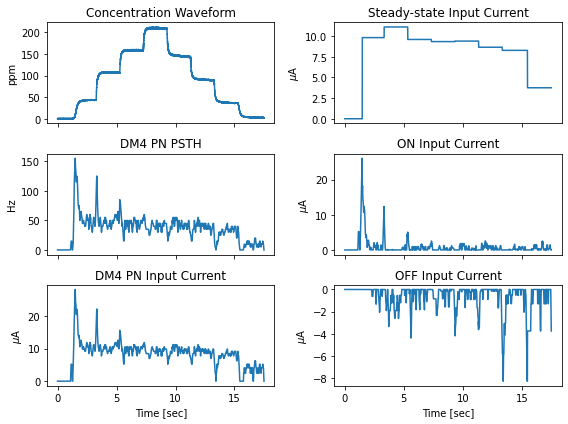

In [8]:
fig, axes = plt.subplots(3,2, figsize=(8,6), sharex=True)
axes[0,0].plot(t, stim)
axes[0,0].set(ylabel='ppm', title='Concentration Waveform')
axes[1,0].plot(t, pn)
axes[1,0].set(ylabel='Hz', title='DM4 PN PSTH')
axes[2,0].plot(t, pn_I)
axes[2,0].set(ylabel='$\mu$A', title='DM4 PN Input Current', xlabel='Time [sec]')
axes[0,1].plot(t, pn_I_ss[0])
axes[0,1].set(ylabel='$\mu$A', title='Steady-state Input Current')
axes[1,1].plot(t, pn_I_on[0])
axes[1,1].set(ylabel='$\mu$A', title='ON Input Current')
axes[2,1].plot(t, pn_I_off[0])
axes[2,1].set(ylabel='$\mu$A', title='OFF Input Current', xlabel='Time [sec]')
fig.tight_layout()

## Simulate Or59b OSN BSG Response to accelerate LN pathway simulation

In [9]:
# nn_osn = Network(solver="euler")
# inp = nn_osn.input(num=1, name='stim')
# osn_otp = nn_osn.add(OTP, num=1, br=dr*aff_or59b, dr=dr, name='OSN-OTP')
# osn_bsg = nn_osn.add(PoissonCSN, num=1, name='OSN-BSG')

# osn_otp(stimulus=inp)
# osn_bsg(I=osn_otp.I)

# osn_bsg.record('x')

# nn_osn.compile()
# inp(garray.to_gpu(np.ascontiguousarray(stim)))
# nn_osn.run(dt, verbose=True)


In [10]:
# osn_bsg_spikerate = osn_bsg.recorder.x[0]
# np.savez('acetone_or59b_osn_bsg_psth', osn_bsg_spikerate)

In [11]:
osn_bsg_spikerate = np.load('acetone_or59b_osn_bsg_psth.npz')['arr_0']

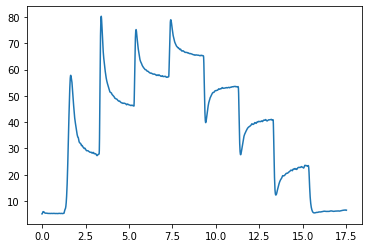

In [12]:
plt.plot(t, osn_bsg_spikerate/dt)

## Define LN Pathway Simulation Helper Functions

In [54]:
def create_network(
    pathway: str, Npop:int, params_dct: tp.Dict, dt: float, 
    /, 
    dtype=float, record_rate: int = 1, verbose:bool = True
) -> Network:
    """Run model with params
    
    Arguments:
        pathway: pathway name (preln, posteln, postiln)
        Npop: number of parameter sets
        params_dct: dictionary of parameters
        dtype: dtype of the model
        record_rate: the output is recorded every x indices
        verbose: whether to show progress bar
        
    Returns:
        `neural.Network` instance for the simulation
    """

    def _create_network_preln(params_dct):
        nn = Network()
        osn_inp = nn.input(num=1, name='OSN-inp')
        osn_repeat = nn.add(Repeat, num=1, rep_size=Npop, name='OSN-BSG')
        osn_axt = nn.add(dDNP, num=Npop, **params_dct["osn_axt"], name="OSN-Axt")
        preln_syn = nn.add(IonSyn, num=Npop, **params_dct["osn-to-preln"], name="OSN to PreLN")
        preln = nn.add(PoissonCSN0, num=Npop, name="Pre-LN")
        osn_axt_to_pn = nn.add(IonSyn, num=Npop, name="OSN-Axt to PN", **params_dct['osn_axt-to-pn'])
        osn_repeat(input=osn_inp)
        osn_axt(u=osn_repeat.output, l=preln.x)
        preln_syn(u=osn_repeat.output)
        preln(I=preln_syn.I)
        osn_axt_to_pn(u=osn_axt.x1)
        osn_axt_to_pn.record('I')
        osn_axt.record('x1')
        preln.record('x')
        return nn

    def _create_network_postiln(params_dct):
        nn = Network()
        osn_inp = nn.input(num=1, name='OSN-inp')
        osn_repeat = nn.add(Repeat, num=1, rep_size=Npop, name='OSN-BSG')
        postiln_syn = nn.add(PostLNSyn, num=Npop, name="OSN to Post-iLN", **params_dct["osn-to-postiln"])
        postiln = nn.add(PoissonCSN0, num=Npop, name="Post-iLN")
        postiln_to_pn = nn.add(IonSyn, num=Npop, name="Post-iLN to PN", **params_dct['postiln-to-pn'])

        osn_repeat(input=osn_inp)
        postiln_syn(u=osn_repeat.output)
        postiln(I=postiln_syn.I)
        postiln_to_pn(u=postiln.x)
        
        postiln_to_pn.record('I')
        postiln.record('x')
        return nn

    def _create_network_posteln(params_dct):
        nn = Network()
        osn_inp = nn.input(num=1, name='OSN-inp')
        osn_repeat = nn.add(Repeat, num=1, rep_size=Npop, name='OSN-BSG')
        posteln_syn = nn.add(PostLNSyn, num=Npop, name="OSN to Post-eLN", **params_dct["osn-to-posteln"])
        posteln = nn.add(PoissonCSN0, num=Npop, name="Post-eLN")
        posteln_to_pn = nn.add(IonSyn, num=Npop, name="Post-eLN to PN", **params_dct['posteln-to-pn'])
        
        osn_repeat(input=osn_inp)
        posteln_syn(u=osn_repeat.output)
        posteln(I=posteln_syn.I)
        posteln_to_pn(u=posteln.x)
        
        posteln_to_pn.record('I')
        posteln.record('x')
        return nn


    func = locals()[f"_create_network_{pathway}"]

    nn = func(params_dct)
    nn.compile(dtype=dtype, backend='cuda')
    return nn


In [22]:
def sample_parameters(
    pathway: str, Npop: int, 
    bounds: tp.List[tp.Tuple[float, float]] = None,
    params_arr: np.ndarray = None,
    batch_size:int = 100,
    seed: int = None, 
) -> tp.Dict:
    """Randomly sample parameters or convert parameter array to dictionary form
    
    """
    if pathway == 'preln':
        # For Pre-LN, we change 4 parameters
        # osn_axt: b1, k
        # osn-to-preln: b1, gmax
        if params_arr is None:
            if bounds is None:
                bounds = [(0, 5.5)] * 4 # log-scale bounds
            else:
                assert len(bounds) == 4
            # random sampling in log-space
            space = skopt.Space(bounds)
            lhs = Lhs(
                criterion=None,
                iterations=min(int(Npop // 100), 10),
                verbose=True,
            )

            x = lhs.generate(space.dimensions, Npop, random_state=seed, batch_size=batch_size)
            params_arr = 10 ** np.array(x).T
        assert params_arr.shape == (4, Npop)
        b1_1, k, b1_2, gmax = params_arr
            
        params = {
            "osn_axt": deepcopy(DEFAULT_PARAMS["osn_axt"]),
            "osn-to-preln": deepcopy(DEFAULT_PARAMS["osn-to-preln"]),
            "osn_axt-to-pn": deepcopy(DEFAULT_PARAMS["osn_axt-to-pn"]),
        }
        params["osn_axt"]["b1"] = np.ascontiguousarray(b1_1)
        params["osn_axt"]["k"] = np.ascontiguousarray(k)
        params["osn-to-preln"]["b1"] = np.ascontiguousarray(b1_2)
        params["osn-to-preln"]["gmax"] = np.ascontiguousarray(gmax)

    elif pathway == 'postiln':
        # For Post-iLN, we change 6 parameters
        # osn-to-postiln: a1, b1, k, b2, b3, gmax
        if params_arr is None:
            if bounds is None:
                bounds = [(0, 5.5)] * 6 # log-scale bounds
            else:
                assert len(bounds) == 6
            # random sampling in log-space
            space = skopt.Space(bounds)
            lhs = Lhs(
                criterion=None,
                iterations=min(int(Npop // 100), 10),
                verbose=True,
            )

            x = lhs.generate(space.dimensions, Npop, random_state=seed, batch_size=batch_size)
            params_arr = 10 ** np.array(x).T
        assert params_arr.shape == (6, Npop)
        a1, b1, k, b2, b3, gmax = params_arr
            
        params = {
            "osn-to-postiln": deepcopy(DEFAULT_PARAMS["osn-to-postiln"]),
            "postiln-to-pn": deepcopy(DEFAULT_PARAMS["postiln-to-pn"]),
        }
        params["osn-to-postiln"]["a1"] = np.ascontiguousarray(a1)
        params["osn-to-postiln"]["b1"] = np.ascontiguousarray(b1)
        params["osn-to-postiln"]["k"] = np.ascontiguousarray(k)
        params["osn-to-postiln"]["b2"] = np.ascontiguousarray(b2)
        params["osn-to-postiln"]["b3"] = np.ascontiguousarray(b3)
        params["osn-to-postiln"]["gmax"] = np.ascontiguousarray(gmax)


    elif pathway == 'posteln':
        # For Post-eLN, we change 6 parameters
        # osn-to-posteln: a1, b1, k, b2, b3, gmax
        if params_arr is None:
            if bounds is None:
                bounds = [(0, 5.5)] * 6 # log-scale bounds
            else:
                assert len(bounds) == 6
            # random sampling in log-space
            space = skopt.Space(bounds)
            lhs = Lhs(
                criterion=None,
                iterations=min(int(Npop // 100), 10),
                verbose=True,
            )

            x = lhs.generate(space.dimensions, Npop, random_state=seed, batch_size=batch_size)
            params_arr = 10 ** np.array(x).T
        assert params_arr.shape == (6, Npop)
        a1, b1, k, b2, b3, gmax = params_arr
        params = {
            "osn-to-posteln": deepcopy(DEFAULT_PARAMS["osn-to-posteln"]),
            "posteln-to-pn": deepcopy(DEFAULT_PARAMS["posteln-to-pn"]),
        }
        params["osn-to-posteln"]["a1"] = np.ascontiguousarray(a1)
        params["osn-to-posteln"]["b1"] = np.ascontiguousarray(b1)
        params["osn-to-posteln"]["k"] = np.ascontiguousarray(k)
        params["osn-to-posteln"]["b2"] = np.ascontiguousarray(b2)
        params["osn-to-posteln"]["b3"] = np.ascontiguousarray(b3)
        params["osn-to-posteln"]["gmax"] = np.ascontiguousarray(gmax)

    else:
        raise ValueError(f"pathway {pathway} not understood")
    
    return params

In [23]:
def cost(
    pathway: str, Npop:int, dt:float, 
    osn_inp_arr:np.ndarray, ground_truth:np.ndarray,
    params_arr: np.ndarray=None, 
    record_rate=100, seed:int = 0,
):
    params = sample_parameters(pathway, Npop, seed=0, params_arr=params_arr)
    nn = create_network(pathway, Npop, params, dt, record_rate=record_rate)
    osn_inp_arr_g = garray.to_gpu(np.ascontiguousarray(osn_inp_arr))

    nn.inputs['OSN-inp'](osn_inp_arr_g)
    nn.run(dt, verbose=pathway, rate=record_rate)
    
    if pathway == 'preln':
        axt_I = nn.containers['OSN-Axt to PN'].recorder.I
        preln_x = nn.containers['Pre-LN'].recorder.x
        axt_x1 = nn.containers['OSN-Axt'].recorder.x1
        axt_dists = angular_dist(axt_I, pn_I_ss[:,::rec_rate])
        axt_x1_max = axt_x1.max(1)
        preln_x_max = preln_x.max(1) / dt
        
        objective = np.squeeze(angular_dist(axt_I, ground_truth[:,::record_rate]))
        valid_mask = np.logical_and.reduce([
            axt_x1_max<.8, preln_x_max>5, preln_x_max<250
        ])
        objective = np.ma.masked_array(objective, mask=~valid_mask)
    elif pathway == 'postiln':
        iln_I = nn.containers['Post-iLN to PN'].recorder.I
        objective = np.squeeze(angular_dist(iln_I, ground_truth[:,::record_rate]))
    elif pathway == 'posteln':
        eln_I = nn.containers['Post-eLN to PN'].recorder.I
        objective = np.squeeze(angular_dist(eln_I, ground_truth[:,::record_rate]))
    else:
        raise ValueError(f"pathway {pathway} not understood")
    return nn, params, objective

## PreLN Optimization

In [143]:
nn_preln, params_preln, obj_preln = cost("preln", int(1e6), dt, osn_bsg_spikerate, pn_I_ss)

{'osn_axt': {'a1': 100.0, 'b1': array([1.10958157e+01, 5.51693929e+01, 6.04175724e+02, ...,
       9.35976310e+04, 2.89042920e+05, 2.92973765e+03]), 'k': array([1.05796395e+01, 2.98559267e+03, 1.52466455e+03, ...,
       1.35674361e+04, 2.02843106e+01, 1.36796807e+04])}, 'osn-to-preln': {'a1': 1.0, 'b1': array([7.35335775e+00, 3.91199893e+00, 4.46819910e+00, ...,
       3.66924311e+04, 1.07999696e+05, 7.84821090e+02]), 'gmax': array([1.65011199e+04, 3.93479647e+04, 2.06254905e+01, ...,
       1.45304229e+03, 1.24292156e+03, 6.06742727e+04])}, 'osn_axt-to-pn': {'a1': 1.0, 'b1': 100.0, 'gmax': 122655.1543619}}


PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

In [168]:
preln_params_arr = np.vstack([
    params_preln['osn_axt']['b1'],
    params_preln['osn_axt']['k'],
    params_preln['osn-to-preln']['b1'],
    params_preln['osn-to-preln']['gmax'],
])

weights = (1-obj_preln[np.argsort(obj_preln)[:1000]].data)
weights /= weights.sum()
mean_params = np.log10(preln_params_arr[:, np.argsort(obj_preln)[:1000]]) @ weights
std_params = np.std(np.log10(preln_params_arr[:, np.argsort(obj_preln)[:1000]]), 1)

preln_params_ranges = [
    (np.clip(mu-2*std, 0, 5.5), np.clip(mu+2*std, 0, 5.5))
    for mu, std in 
    zip(mean_params, std_params)
]
print(preln_params_ranges)

[(0.0, 3.12611408916038), (1.2146995881410585, 5.229970809938703), (0.304580085078357, 2.28082760444001), (3.76365384475094, 5.5)]


In [183]:
def preln_cost(x, dt:float, osn_inp_arr:np.ndarray, ground_truth:np.ndarray, record_rate=100):
    Npop = x.shape[1]
    nn, params, obj = cost(
        "preln", Npop, dt, 
        osn_inp_arr, ground_truth,
        params_arr=10 ** x, record_rate=record_rate
    )
    obj_true = obj.data
    obj_true[obj.mask] = np.inf # maximum dists
    return obj_true

In [184]:
preln_de_solver = DESolver(
    preln_cost,
    bounds=preln_params_ranges,
    args=(dt, osn_bsg_spikerate, pn_I_ss, 100),
    batched=True,
    verbose=True,
    polish=False,
    popsize=500,
    maxiter=100
)
opt_res_preln = preln_de_solver.solve()

/mnt/server-home/tingkai/Project/adult/antennal_lobe/antennal_lobe/experiments/differential_evolution.py:529: UserWarning: differential_evolution: the 'batched' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn(


[DE deferred 4]:   0%|          | 0/100 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

In [198]:
print(opt_res_preln)

     fun: 0.08021843075718796
 history: Optimization History with 37 Steps
 message: 'Optimization terminated successfully.'
    nfev: 74000
     nit: 36
 success: True
       x: array([0.75883257, 2.88465791, 1.95415132, 5.40901993])


In [186]:
nn_preln_best, _, preln_best_obj = cost(
    "preln", 1, dt, 
    osn_bsg_spikerate, pn_I_ss,
    params_arr=10 ** opt_res_preln.x[:,None], 
    record_rate=100
)

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

In [188]:
nn_preln_best.containers

OrderedDict([('OSN-BSG', <neural.network.network.Container at 0x7f912c2e14f0>),
             ('OSN-Axt', <neural.network.network.Container at 0x7f93367e7130>),
             ('OSN to PreLN',
              <neural.network.network.Container at 0x7f9335ffa430>),
             ('Pre-LN', <neural.network.network.Container at 0x7f9333a4e9a0>),
             ('OSN-Axt to PN',
              <neural.network.network.Container at 0x7f9333a2c340>)])

In [65]:
plt.plot(t[::100], nn_preln_best.containers['OSN-Axt to PN'].recorder.I[0])
plt.plot(t[::100], pn_I_ss[0,::100])

NameError: name 'nn_preln_best' is not defined

## Post-eLN Optimization

In [66]:
nn_posteln, params_posteln, obj_posteln = cost(
    "posteln", int(1e6), dt, osn_bsg_spikerate[t<=9], pn_I_on[:, t<=9], seed=1
)

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

In [76]:
posteln_params_arr = np.vstack([
    params_posteln["osn-to-posteln"]["a1"],
    params_posteln["osn-to-posteln"]["b1"],
    params_posteln["osn-to-posteln"]["k"],
    params_posteln["osn-to-posteln"]["b2"],
    params_posteln["osn-to-posteln"]["b3"],
    params_posteln["osn-to-posteln"]["gmax"],
])

weights = (1-obj_posteln[np.argsort(obj_posteln)[:100]])
weights /= weights.sum()
mean_params = np.log10(posteln_params_arr[:, np.argsort(obj_posteln)[:100]]) @ weights
std_params = np.std(np.log10(posteln_params_arr[:, np.argsort(obj_posteln)[:100]]), 1)

posteln_params_ranges = [
    (np.clip(mu-std, 0, 5.5), np.clip(mu+std, 0, 5.5))
    for mu, std in 
    zip(mean_params, std_params)
]
print("Post-eLN Best Param Random Sampling", np.log10(posteln_params_arr[:, np.argmin(obj_posteln)]))
print("Post-eLN Param Range", posteln_params_ranges)

Post-eLN Best Param Random Sampling [5.09671918 0.15700566 5.48471229 5.32243987 0.95397565 4.60244093]
Post-eLN Param Range [(3.330531469278038, 5.1653322089939735), (0.0, 1.3358843112325616), (5.009371824113072, 5.466201304689544), (1.985916278199712, 4.282739511719924), (0.7925295707117013, 1.2586134542788516), (3.6025028607127485, 5.267952534361893)]


Text(0.5, 1.0, '0.48507514367090576')

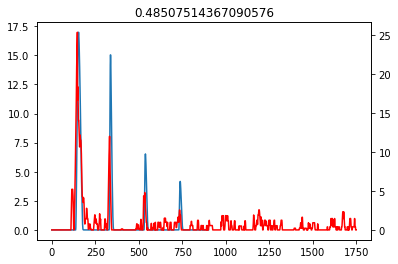

In [77]:
fig,ax = plt.subplots(1,1)
ax.plot(nn_posteln.containers['Post-eLN to PN'].recorder.I[np.argsort(obj_posteln)[0]])
ax2 = ax.twinx()
ax2.plot(pn_I_on[0,::100], c='r')
ax.set_title(np.min(obj_posteln))



In [78]:
def posteln_cost(x, dt:float, osn_inp_arr:np.ndarray, ground_truth:np.ndarray, record_rate=100):
    Npop = x.shape[1]
    nn, params, obj = cost(
        "posteln", Npop, dt, 
        osn_inp_arr, ground_truth,
        params_arr=10 ** x, record_rate=record_rate
    )
    return obj

In [ ]:
posteln_de_solver = DESolver(
    posteln_cost,
    bounds=posteln_params_ranges,
    args=(dt, osn_bsg_spikerate[t<=9], pn_I_on[:, t<=9], 100),
    batched=True,
    verbose=True,
    polish=False,
    popsize=500,
    maxiter=100
)
opt_res_posteln = posteln_de_solver.solve()

/mnt/server-home/tingkai/Project/adult/antennal_lobe/antennal_lobe/experiments/differential_evolution.py:529: UserWarning: differential_evolution: the 'batched' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn(


[DE deferred 6]:   0%|          | 0/100 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

posteln:   0%|          | 0/90001 [00:00<?, ?it/s]

In [ ]:
print(opt_res_posteln)

In [ ]:
nn_posteln_best, _, posteln_best_obj = cost(
    "posteln", 1, dt, 
    osn_bsg_spikerate, pn_I_on,
    params_arr=10 ** opt_res_posteln.x[:,None], 
    record_rate=100
)

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(nn_posteln_best.containers['Post-eLN to PN'].recorder.I[0])
ax2 = ax.twinx()
ax2.plot(pn_I_on[0,::100], c='r')

## Post-iLN Optimization

In [55]:
nn_postiln, params_postiln, obj_postiln = cost(
    "postiln", int(1e6), dt, osn_bsg_spikerate, pn_I_on, seed=1
)

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

In [56]:
postiln_params_arr = np.vstack([
    params_postiln["osn-to-postiln"]["a1"],
    params_postiln["osn-to-postiln"]["b1"],
    params_postiln["osn-to-postiln"]["k"],
    params_postiln["osn-to-postiln"]["b2"],
    params_postiln["osn-to-postiln"]["b3"],
    params_postiln["osn-to-postiln"]["gmax"],
])

weights = (1-obj_postiln[np.argsort(obj_postiln)[:1000]])
weights /= weights.sum()
mean_params = np.log10(postiln_params_arr[:, np.argsort(obj_postiln)[:1000]]) @ weights
std_params = np.std(np.log10(postiln_params_arr[:, np.argsort(obj_postiln)[:1000]]), 1)

postiln_params_ranges = [
    (np.clip(mu-std, 0, 5.5), np.clip(mu+std, 0, 5.5))
    for mu, std in 
    zip(mean_params, std_params)
]
print(postiln_params_ranges)

[(2.8977544215339193, 5.144069741090522), (0.0, 1.9807410971542279), (2.2501762015710653, 5.251213132485358), (0.16601954010683073, 2.9908871374660757), (0.1928259782072821, 3.135329083037001), (3.591570225619202, 5.185893555047754)]


Post-eLN Best Param Random Sampling [5.40313773 0.20289962 5.42517747 3.06521653 1.14270462 2.79957663]


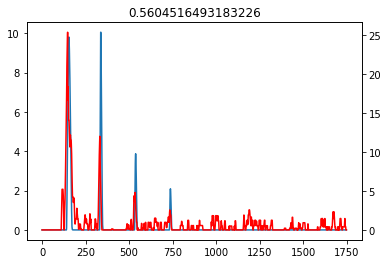

In [59]:
fig,ax = plt.subplots(1,1)
ax.plot(nn_postiln.containers['Post-iLN to PN'].recorder.I[np.argsort(obj_postiln)[0]])
ax2 = ax.twinx()
ax2.plot(pn_I_on[0,::100], c='r')
ax.set_title(np.min(obj_postiln))

print("Post-iLN Best Param Random Sampling", np.log10(postiln_params_arr[:, np.argsort(obj_postiln)[0]]))

In [60]:
def postiln_cost(x, dt:float, osn_inp_arr:np.ndarray, ground_truth:np.ndarray, record_rate=100):
    Npop = x.shape[1]
    nn, params, obj = cost(
        "postiln", Npop, dt, 
        osn_inp_arr, ground_truth,
        params_arr=10 ** x, record_rate=record_rate
    )
    return obj

In [ ]:
postiln_de_solver = DESolver(
    postiln_cost,
    bounds=postiln_params_ranges,
    args=(dt, osn_bsg_spikerate, pn_I_on, 100),
    batched=True,
    verbose=True,
    polish=False,
    popsize=500,
    maxiter=100
)
opt_res_postiln = postiln_de_solver.solve()

/mnt/server-home/tingkai/Project/adult/antennal_lobe/antennal_lobe/experiments/differential_evolution.py:529: UserWarning: differential_evolution: the 'batched' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn(


[DE deferred 6]:   0%|          | 0/100 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

In [36]:
print(opt_res_postiln)

     fun: 0.5084236978709672
 history: Optimization History with 101 Steps
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 303000
     nit: 100
 success: False
       x: array([4.51493731e+00, 4.01154678e-03, 5.24425259e+00, 3.12079933e+00,
       1.00751965e+00, 5.10238741e+00])


In [37]:
nn_postiln_best, _, postiln_best_obj = cost(
    "postiln", 1, dt, 
    osn_bsg_spikerate, pn_I_on,
    params_arr=10 ** opt_res_postiln.x[:,None], 
    record_rate=100
)

posteln:   0%|          | 0/175000 [00:00<?, ?it/s]

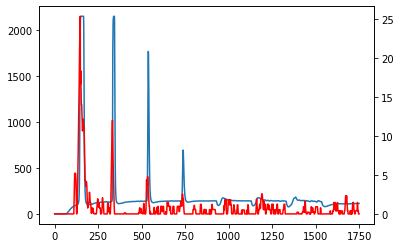

In [41]:
fig,ax = plt.subplots(1,1)
ax.plot(nn_postiln_best.containers['Post-eLN to PN'].recorder.I[0])
ax2 = ax.twinx()
ax2.plot(pn_I_on[0,::100], c='r')

In [ ]:
def find_best_gmax_all(mod2_x1, pn_spk, mask=None, est_rate=1):
    best_scales_all = np.zeros(mod2_x1.shape[0])
    max_batch_size = 5000
    start_indices = np.arange(mod2_x1.shape[0])[::max_batch_size]
    if mask is None:
        mask = np.full(pn_spk.shape[1], True)

    mod2_max_amps = mod2_x1[:, mask].max(1)
    mod2_norm = mod2_x1/(1e-10 + mod2_max_amps[:,None])

    pn_spk = pn_spk[:, ::est_rate]
    mask = mask[::est_rate]
    for start in tqdm(start_indices, total=len(start_indices), desc='Finding Best Gmax'):
        stop = min(start+max_batch_size, mod2_x1.shape[0])
        _mod2 = mod2_norm[start:stop, ::est_rate]
        scales = np.linspace(0, 50., 1000)
        pn_x = np.clip(
            estimate_spike_rate(scales[:,None,None] * _mod2[None,...], resting=0),
            0,
            500
        )
        dists = pairwise_distances(
            pn_x.reshape((-1, pn_x.shape[-1]))[:, mask],
            pn_spk[:, mask]
        )
        inactive_mask = np.all(pn_x.reshape((-1, pn_x.shape[-1]))==0, axis=1)
        dists[inactive_mask] = np.inf
        dists = dists.reshape((len(scales), -1))
        best_scales = scales[np.argmin(dists, 0)]
        best_scales_all[start:stop] = best_scales
    best_scales_all = best_scales_all / (1e-15 + mod2_max_amps)
    return best_scales_all

if __name__ == '__main__':
    import argparse
    import os
    import json
    import warnings
    from tensorboardX import SummaryWriter
    warnings.filterwarnings("ignore")

    parser = argparse.ArgumentParser(description='Brute Force Model Parameter Search')
    parser.add_argument(
        '--model',
        type=str,
        choices=['global_ff', 'global_fb', 'global_fffb', 'local_ff', 'local_fb', 'local_fffb'],
        help='Model Name'
    )
    parser.add_argument('-dt', default=1e-4, type=float, help="Time Resolution")
    parser.add_argument('-sr', '--sim_rate', default=1, type=int, help="Simulation Rate")
    parser.add_argument('-rr', '--rec_rate', default=10, type=int, help="Record Rate")
    parser.add_argument('-Ns', '--N_samples', default=100, type=int, help="Number of samples in each dimension of the parameter set")
    parser.add_argument('-bs', '--batch_size', default=5000, type=int, help="Number of parameters to run at the same time")
    parser.add_argument('--max_samples', default=int(1e8), type=int, help="Maximum number of possible samples")
    parser.add_argument('-v', '--verbose', default=True, type=bool, help="Verbose")
    args = parser.parse_args()
    cfg = dict(json.load(open('./optimization_config.json', 'r')))

    """ Load Data """
    CURR_DIR = os.path.dirname(os.path.abspath(__file__))
    physio_data_dir = os.path.join(os.path.dirname(os.path.dirname(CURR_DIR)), 'physio_data')
    phys_data = dict(np.load(os.path.join(physio_data_dir, 'ant_al_io.npz'), allow_pickle=True))
    pn_data = dict(np.load(os.path.join(physio_data_dir, 'pn_data.npz'), allow_pickle=True))
    for key,val in pn_data.items():
        try:
            pn_data[key] = val.item()
        except:
            pass

    door_est = pd.read_csv(os.path.join(physio_data_dir, 'estimated_affinity.csv'), index_col=0)

    t_orig = phys_data['t']
    t_sim = np.arange(t_orig.min(), t_orig.max()+args.dt/2, args.dt)
    stim = np.interp(t_sim, t_orig, phys_data['stim'][0])[None,:]
    ref = np.interp(t_sim, t_orig, phys_data['pn'][0])[None,:]
    osn_bsg_acetone = np.load('../tmp_full.npz')['osn']
    I_59b = estimate_current(ref, resting=0)

    """ Creat Parameters """
    bounds = np.array(cfg["bounds"][args.model])
    params = np.array(list(product(
        *[np.linspace(bd[0], bd[1], args.N_samples) for bd in bounds]
    ))).T
    if params.shape[1] > args.max_samples:
        warnings.warn(
            f"Actual number of parameters ({params.shape[1]}) is larger than "
            f"max ({args.max_samples})"
        )
    params = params[:, :args.max_samples]
    df_res = pd.DataFrame(
        {
            **{f"param-{n}":p for n,p in enumerate(params)},
            **{
                "angular_59b":np.full(params.shape[-1], -np.inf),
                "snr_59b":np.full(params.shape[-1], -np.inf),
                "l2_59b":np.full(params.shape[-1], -np.inf),
                "avg_pn_dist":np.full(params.shape[-1], -np.inf),
            }
        }
    )

    best_params_overall = None
    best_angular_overall = np.inf
    logdir = f"brute_runs/{args.model}-{datetime.now().strftime('%b%d_%H-%M-%S')}"
    res_dir = os.path.join(logdir, 'results')
    with SummaryWriter(logdir) as wrt:
        wrt.add_text('model', args.model, 0)
        if not os.path.exists(res_dir):
            os.mkdir(res_dir)

        pbar = tqdm(
            enumerate(np.arange(params.shape[1])[::args.batch_size]),
            total=len(np.arange(params.shape[1])[::args.batch_size]),
            desc=f"{args.model}|{params.shape[1]}"
        )
        for n_it, start in pbar:
            stop = min(start+args.batch_size, params.shape[1])
            params_batch = params[:, start:stop]
            nn = run_model(
                args.model,
                params_batch,
                args.dt,
                osn_bsg_acetone,
                sim_rate=args.sim_rate,
                record_rate=args.rec_rate,
                verbose=False
            )

            if n_it == 0:
                wrt.add_text(
                    'model source',
                    inspect.getsource(nn.containers['Model 2'].obj.__class__),
                    n_it
                )

            mod_x1 = nn.containers['Model 2'].recorder.x1
            if 'global' in args.model:
                mod_x1 = mod_x1.reshape((door_est.shape[1], -1, mod_x1.shape[-1]))[14]

            best_gmax_all = find_best_gmax_all(
                mod_x1,
                ref[:, ::args.sim_rate*args.rec_rate],
                mask=np.logical_and(t_sim>5, t_sim<20)[::args.sim_rate*args.rec_rate],
                est_rate=100
            )
            pn_x = estimate_spike_rate(
                best_gmax_all[:,None] * mod_x1,
                resting=0
            )

            ang_dist = np.atleast_1d(np.squeeze(angular_dist(
                pn_x,
                ref[:,::args.sim_rate*args.rec_rate]
            )))
            # mask = (I_59b >= 7.6)[0, ::args.sim_rate*args.rec_rate]
            # ang_dist = np.atleast_1d(np.squeeze(angular_dist(
            #     mod_x1[:, mask],
            #     I_59b[:,::args.sim_rate*args.rec_rate][:,mask]
            # )))


            x1_too_large = mod_x1.max(-1) > 0.8
            snr_all = np.squeeze(average_snr(
                ref[:, ::args.sim_rate*args.rec_rate],
                pn_x,
                axis=1
            ))
            l2_all = np.squeeze(np.linalg.norm(
                ref[:, ::args.sim_rate*args.rec_rate] -
                pn_x,
                axis=1
            ))

            valid_mask= np.logical_not(x1_too_large)
            best_param_idx = np.arange(len(snr_all))[valid_mask][np.argmax(snr_all[valid_mask])]
            best_mod1 = mod_x1[best_param_idx]
            best_ang = ang_dist[best_param_idx]
            best_params = params_batch[:, best_param_idx]
            best_gmax = best_gmax_all[best_param_idx]
            best_59b = pn_x[best_param_idx]
            best_snr = snr_all[best_param_idx]
            best_l2 = l2_all[best_param_idx]

            # best_param_idx = np.argmin(ang_dist + x1_too_large.astype(float))
            # best_mod1 = mod_x1[best_param_idx]
            # best_ang = ang_dist[best_param_idx]
            # best_params = params_batch[:, best_param_idx]
            # best_gmax = get_best_scale(best_mod1, ref[0], sim_rate=args.sim_rate, rec_rate=args.rec_rate, est_rate=1)
            # best_59b = estimate_spike_rate(best_gmax * best_mod1, resting=0)
            # best_snr = average_snr(ref[0][::args.sim_rate*args.rec_rate], best_59b)
            # best_l2 = np.linalg.norm(ref[0][::args.sim_rate*args.rec_rate] - best_59b)

            if best_params_overall is None:
                best_params_overall = best_params
                best_angular_overal = best_ang
                best_snr_overall = best_snr
                best_l2_overall = best_l2
            else:
                if best_ang < best_angular_overal:
                    best_params_overall = best_params
                    best_l2_overall = best_l2
                    best_snr_overall = best_snr
                    best_angular_overall = best_ang

            wrt.add_scalar('Ang. 59b', best_angular_overall, n_it)
            wrt.add_scalar('ASNR 59b', best_snr_overall, n_it)
            wrt.add_scalar('l2 59b', best_l2_overall, n_it)
            wrt.add_scalars(
                'params',
                {
                    **{f'param-{n}': p for n,p in enumerate(best_params_overall)},
                    **{'gmax': best_gmax}
                },
                n_it
            )
            pbar.set_description(f"{args.model} | {params.shape[1]} | Ang {best_angular_overal:.3f} | SNR {best_snr_overall:.1f} dB | l2 {best_l2_overall:.1f}")

            df_res.loc[df_res.index[start:stop], "angular_59b"] = ang_dist
            df_res.loc[df_res.index[start:stop], "valid"] = valid_mask
            df_res.loc[df_res.index[start:stop], "snr_59b"] = snr_all
            df_res.loc[df_res.index[start:stop], "l2_59b"] = l2_all

            fig,axes = plt.subplots(2,1,figsize=(8,6), sharex=True)
            ax = axes[0]
            ax.plot(
                t_sim[::args.sim_rate*args.rec_rate],
                best_mod1*best_gmax,
                c='r',
                label=f"Ang={best_ang:.3f}"
            )
            ax.plot(t_sim, I_59b[0], '-k', alpha=.6, label='Current')

            ax = axes[1]
            ax.plot(
                t_sim[::args.sim_rate*args.rec_rate],
                best_59b,
                c='r',
                label=f"SNR={best_snr:.1f} dB, l2={best_l2:.1f}"
            )
            ax.plot(t_sim, ref[0], '-k', alpha=.6, label='Physiology Data')

            for ax in axes:
                ax.grid()
                ax.legend()
            axes[0].set_ylabel("Current [$\mu A$]")
            axes[1].set_ylabel("PSTH [Hz]")
            axes[0].set_title(args.model)
            wrt.add_figure('Or59b Result', fig, n_it)

            affs = door_est.values
            concs = 10**np.linspace(0,4,30)
            mixture_ratios = np.vstack([np.eye(110)*c for c in concs])
            N_w, N_odorants = mixture_ratios.shape
            N_r = affs.shape[1]
            wav = generate_stimulus('step', args.dt, 3., (.0, 3.), 1., sigma=0.)


            if 'fffb' not in args.model:
                model_params = dict(
                    a1=best_params[0],b1=best_params[1],kappa=best_params[2],
                    a2=best_params[3],b2=best_params[4],
                    gmax=best_gmax
                )
            else:
                model_params = dict(
                    a1=best_params[0],b1=best_params[1],kappa=best_params[2],
                    a2=best_params[3],b2=best_params[4],
                    a3=best_params[5],b3=best_params[6],gamma=best_params[7],
                    gmax=best_gmax
                )

            nn  = create_network(
                affs,
                mixture_ratios,
                args.dt,
                models=[args.model],
                model_params={args.model:model_params},
                record=False
            )
            for n in range(N_odorants):
                nn.inputs[f'waveform{n}'](wav)
            nn.run(args.dt, verbose=False, rate=args.rec_rate)

            osn_aff_dist = cost_against_affs_ss(
                nn.containers['BSG'].obj.x.reshape(
                    (len(concs), N_odorants, N_r)
                ).get() / args.dt,
                door_est.values
            )
            mod_res = nn.containers[args.model].obj.x1.reshape(
                (len(concs), N_odorants, N_r)
            ).get()
            mod_aff_dist = cost_against_affs_ss(mod_res, door_est.values)

            pn_res = nn.containers[f'PN-{args.model}'].obj.x.reshape(
                (len(concs), N_odorants, N_r)
            ).get()/args.dt
            pn_aff_dist = cost_against_affs_ss(pn_res, door_est.values)

            fig, axes = plt.subplots(2, 3+1, figsize=(12,7),gridspec_kw=dict(width_ratios=[10]*3+[1], hspace=.4))
            cs = plt.cm.get_cmap('coolwarm',len(concs))
            for n1, _mod in enumerate(['osn', 'mod', 'pn']):
                nplt.plot_mat(
                    globals()[f'{_mod}_aff_dist'],
                    y=concs,
                    vmin=0, vmax=1,
                    ax=axes[0,n1],
                    cax=axes[0,-1] if n1==0 else False,
                    cbar_kw=dict(label='Distance w.r.t. Affinity'),
                    shading='nearest',
                    rasterized=True,
                    cmap=plt.cm.coolwarm,
                )
                axes[0,n1].set_title(f"{_mod}")
                axes[0,n1].set_yscale('log')
                axes[0,n1].set_xlabel("Odorant Index")

                if n1 == 0:
                    axes[0,n1].set_ylabel("Concentration [ppm]")
                else:
                    axes[0,n1].set_yticklabels([])
                    for n_c, (_out1, _out2) in enumerate(zip(
                        osn_aff_dist,
                        globals()[f'{_mod}_aff_dist']
                    )):
                        axes[1,n1].scatter(
                            _out1,
                            _out2,
                            c=[cs(n_c)],
                            s=1,
                            alpha=.5,
                            rasterized=True
                        )
                    axes[1,n1].plot([0,1], [0,1], c='k')
                    axes[1,n1].axis('square')
                    axes[1,n1].set_xlim([-0.1,1.1])
                    axes[1,n1].set_ylim([-0.1,1.1])
                    axes[1,n1].grid()
                    axes[1,n1].set_xlabel("$d(OSN, Aff.)$")
                    axes[1,n1].set_ylabel(f"$d({_mod.upper()}, Aff.)$")
            axes[1,0].remove()
            norm = mpl.colors.BoundaryNorm(concs, plt.cm.coolwarm.N)
            cb = mpl.colorbar.ColorbarBase(
                axes[1,-1], cmap=plt.cm.coolwarm, norm=norm,
                spacing='proportional', ticks=concs, boundaries=concs
            )
            axes[1,-1].set_yscale('log')
            fig.suptitle(args.model, fontsize=15)

            wrt.add_figure('Affinity Distance', fig, n_it)

            df_res.loc[df_res.index[start:stop][best_param_idx], "avg_pn_dist"] = np.mean(pn_aff_dist[np.isfinite(pn_aff_dist)])
            df_res.to_csv(f"{logdir}/results.csv")
            np.savez(
                os.path.join(res_dir, f'iter_{n_it}'),
                **dict(
                    params=params_batch,
                    best_params = best_params,
                    best_ang = best_ang,
                    best_snr = best_snr,
                    best_l2 = best_l2,
                    best_gmax = best_gmax,
                    best_mod1 = best_mod1,
                    best_59b = best_59b,
                    pn_res = pn_res,
                    osn_aff_dist=osn_aff_dist,
                    pn_aff_dist = pn_aff_dist,
                    mod_res = mod_res,
                    mod_aff_dist = mod_aff_dist,
                    start_idx=start,
                    stop_idx=stop
                )
            )